# CV Assignment 2
### Laksh Nanwani - 2021701002

In [328]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
import helper
import os

In [329]:
def show_image(img, title = "", figsize = -1):
    if figsize != -1:
        plt.figure(figsize = figsize)
    plt.imshow(img, cmap = 'gray')
    plt.axis("off")
    plt.title(title)
    plt.show()

### 2 Single-Scale Lucas-Kanade Optical Flow

__2.1 Keypoint Selection: Selecting Pixels to Track__

In [330]:
def sobel(gray, direction):
    if direction == 'x':
        kernel = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]])
    elif direction == 'y':
        kernel = np.array([[1, 2, 1], 
                            [0, 0, 0], 
                            [-1, -2, -1]])

    return convolve2d(gray, kernel, mode = 'same')

In [331]:
def harris_corner(gray_img, thresh, k, window_size, number_best = -1):
    gray = gray_img.copy() / 255
    Ix, Iy = sobel(gray, 'x'), sobel(gray, 'y')

    # Ixx = Ix**2
    # Ixy = Iy * Ix
    # Iyy = Iy**2
    sigma = 2
    window = 7
    Ixx = gaussian_filter(Ix*Ix, sigma, truncate=(((window - 1)/2)-sigma)/sigma)
    Ixy = gaussian_filter(Ix*Iy, sigma, truncate=(((window - 1)/2)-sigma)/sigma)
    Iyy = gaussian_filter(Iy*Iy, sigma, truncate=(((window - 1)/2)-sigma)/sigma)
    # offset_i, offset_j = window_size[0] // 2, window_size[1] // 2

    corners = []

    determinant = Ixx*Iyy - Ixy**2
    trace = Ixx + Iyy
    response = determinant - k*(trace**2)

    corner_indices = np.where((response > thresh * np.max(response)))

    corners = np.zeros((len(corner_indices[0]), 3))
    corners[:, 0] = corner_indices[1]
    corners[:, 1] = corner_indices[0]
    corners[:, 2] = response[corner_indices]

    corners = corners[corners[:, 2].argsort()]

    if len(corners) <= number_best:
        return corners
    corners = corners[0:number_best, 0:2].astype(int)
    return corners

In [332]:
def add_corners(img, corners, only_corners = False, color = ((255,0,0))):
    if only_corners:
        out = np.zeros(img.shape)
    else:
        out = img.copy()
        
    for c in corners:
        # out[c[1], c[0]] = color
        cv2.circle(out, (c[0], c[1]), 3, color, -1)

    return out

In [333]:
def shi_tomasi_corner(gray_img, thresh, window_size, number_best = 100):
    gray = gray_img.copy() / 255
    Ix, Iy = sobel(gray, 'x'), sobel(gray, 'y')

    # Ixx = Ix**2
    # Ixy = Iy * Ix
    # Iyy = Iy**2
    sigma = 2
    window = 7
    Ixx = gaussian_filter(Ix*Ix, sigma, truncate=(((window - 1)/2)-sigma)/sigma)
    Ixy = gaussian_filter(Ix*Iy, sigma, truncate=(((window - 1)/2)-sigma)/sigma)
    Iyy = gaussian_filter(Iy*Iy, sigma, truncate=(((window - 1)/2)-sigma)/sigma)

    # offset_i, offset_j = window_size[0] // 2, window_size[1] // 2

    response = np.zeros((Ix.shape[0], Ix.shape[1]))

    for i in range(Ix.shape[0]):
        for j in range(Ix.shape[1]):
            H = np.array([[Ixx[i][j], Ixy[i][j]],
                          [Ixy[i][j], Iyy[i][j]]])

            w, _ = np.linalg.eig(H)
            ##print(w)
            response[i][j] = np.min(w)

    corner_indices = np.where((response > thresh * np.max(response)))

    corners = np.zeros((len(corner_indices[0]), 3))
    corners[:, 0] = corner_indices[1]
    corners[:, 1] = corner_indices[0]
    corners[:, 2] = response[corner_indices]

    corners = corners[corners[:, 2].argsort()]

    if len(corners) <= number_best:
        return corners
    corners = corners[0:number_best, 0:2].astype(int)
    return corners

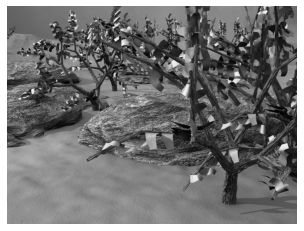

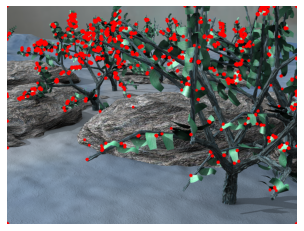

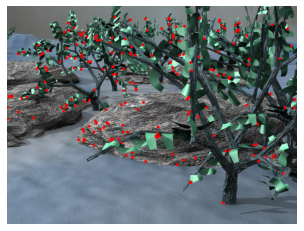

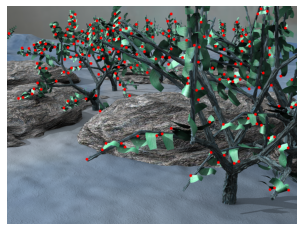

In [334]:
img = cv2.imread("../data/all-frames-colour/Grove3/frame07.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(gray)

corners_h = harris_corner(gray, 0.07, 0.04, (5,5))
show_image(add_corners(img, corners_h))

corners_s = shi_tomasi_corner(gray, 0.07, (5,5), 200)
show_image(add_corners(img, corners_s))

corners_cv2 = (cv2.goodFeaturesToTrack(gray, 200, 0.05, 10)).reshape((-1, 2)).astype(int)
show_image(add_corners(img, corners_cv2))

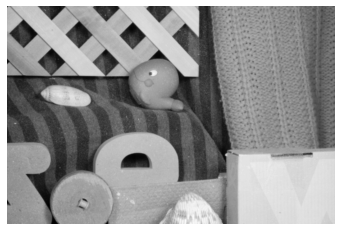

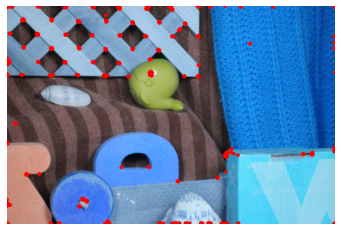

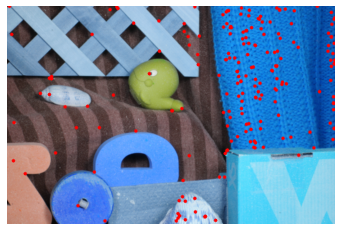

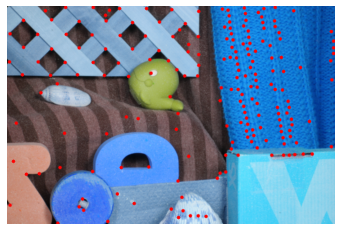

In [335]:
img = cv2.imread("../data/all-frames-colour/RubberWhale/frame07.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(gray)

corners_h = harris_corner(gray, 0.005, 0.02, (5,5))
show_image(add_corners(img, corners_h))

corners_s = shi_tomasi_corner(gray, 0.02, (5,5), 200)
show_image(add_corners(img, corners_s))

corners_cv2 = (cv2.goodFeaturesToTrack(gray, 200, 0.05, 10)).reshape((-1, 2)).astype(int)
show_image(add_corners(img, corners_cv2))

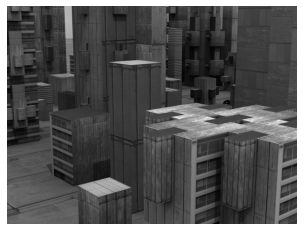

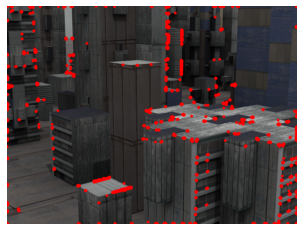

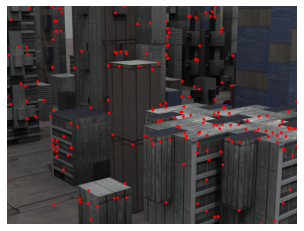

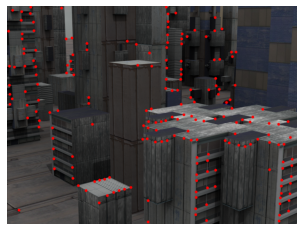

In [336]:
img = cv2.imread("../data/all-frames-colour/Urban2/frame07.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(gray)

corners_h = harris_corner(gray, 0.01, 0.04, (5,5))
show_image(add_corners(img, corners_h))

corners_s = shi_tomasi_corner(gray, 0.02, (5,5), 200)
show_image(add_corners(img, corners_s))

corners_cv2 = (cv2.goodFeaturesToTrack(gray, 200, 0.05, 10)).reshape((-1, 2)).astype(int)
show_image(add_corners(img, corners_cv2))

__2.2 Forward-Additive Sparse Optical Flow__

In [337]:
def LukasKanadeForwardAdditive(img1, img2, windowSize, corners = [], thresh = 0.01, num_corners = 200):
    Ix = sobel(img1, 'x')
    Iy = sobel(img1, 'y')
    It = img2 - img1

    IxIt = Ix*It
    IyIt = Iy*It
    
    if corners == []:
        corners = (cv2.goodFeaturesToTrack(img1, num_corners, 0.05, 10)).reshape((-1, 2)).astype(int)
    
    offset_i, offset_j = windowSize[0] // 2, windowSize[1] // 2

    corners_and_flow = []

    for c in corners:
        j, i = c[0:2]
        i_start, i_end = i - offset_i, i + offset_i + 1
        j_start, j_end = j - offset_j, j + offset_j + 1

        if not isValid(i_start, i_end, j_start, j_end, Ix.shape):
            continue

        A = get_A(Ix[i_start:i_end, j_start:j_end], Iy[i_start:i_end, j_start:j_end])
        # print(A.shape)
        # b = It[i_start:i_end, j_start:j_end].flatten().T
        
        ATA = A.T @ A
        # ATb = A.T @ b
        B = np.array([[np.sum(IxIt[i_start:i_end, j_start:j_end]), 
                       np.sum(IyIt[i_start:i_end, j_start:j_end])]]).T

        w,_ = np.linalg.eig(ATA)

        if np.min(w) < thresh:
            # corners_and_flow.append([c[0:2], [0,0]])
            continue
        # else:
        flow = -np.linalg.inv(ATA) @ B
        corners_and_flow.append([c[0], c[1], flow[0,0], flow[1,0]])
        
    return np.array(corners_and_flow)

def isValid(i_start, i_end, j_start, j_end, shape):
    if i_start >= 0 and j_start >= 0 and i_end < shape[0] and j_end < shape[1]:
        return True
    return False

def get_A(Ix, Iy):
    # A = np.zeros((Ix.shape[0] * Ix.shape[1], 2))
    A = np.vstack(((Ix.flatten()), Iy.flatten())).T
    # A[:, 0] = Ix.reshape(-1)
    # A[:, 1] = Iy.reshape(-1)
    return A

In [344]:
def get_images(path):
    colored = []
    gray = []

    for name in sorted(os.listdir(path)):
        img = cv2.imread(path + name)
        colored.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # gray_img = gray_img - np.min(gray_img)
        # gray_img = gray_img / np.max(gray_img)

        gray.append(gray_img)

    return colored, gray

In [339]:
def add_flow_to_image(img, points_and_flows, only_flow = False, figsize = (5,5)):
    # if only_flow:
    #     out = np.zeros(img.shape)
    # else:
    #     out = img.copy()
    plt.figure(figsize = figsize)
    if not only_flow:
        plt.imshow(img)
    
    for pf in points_and_flows:
        x,y = pf[0], pf[1]
        u,v = pf[2], pf[3]
        # pt1 = (x,y)
        # pt2 = (int(x+u), int(y+v))
        # print(x,y)
        # plt.Circle((x,y), 1)
        plt.quiver(x,y,u,v, scale_units='xy', color = 'r')

    # return out
    plt.axis('off')
    plt.show()

In [347]:
def average_end_point_error(pf1, pf2):
    flow1 = pf1[:, 2:]
    flow2 = pf2[:, 2:]
    return np.mean(np.linalg.norm(flow1 - flow2, axis= 1))

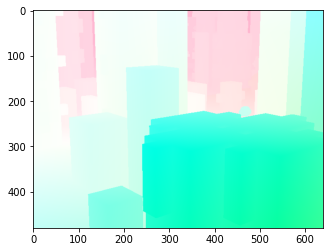

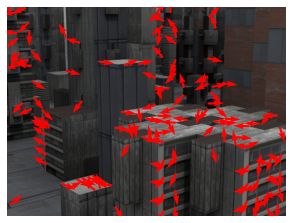

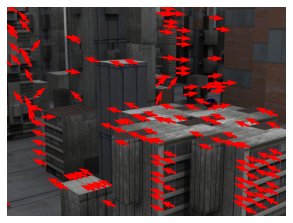

Average end point error =  11.130135337356563


In [348]:
urban_color, urban_gray = get_images("../data/all-frames-colour/Urban2/")
urban_gt_flow = helper.read_flow("../data/ground-truth-flow/Urban2/flow10.flo")
# print(urban_gt_flow)

helper.show_flow("../data/ground-truth-flow/Urban2/flow10.flo")

u = urban_gt_flow[:, :, 0]
v = urban_gt_flow[:, :, 1]
# print(u)

k = 3
flow_gt = []
points_and_flows = LukasKanadeForwardAdditive(urban_gray[k], urban_gray[k+1], (5,5), thresh=0.01, num_corners=150)
for pf in points_and_flows:
    j,i = int(pf[0]), int(pf[1])
    flow_gt.append([j, i, u[i,j], v[i,j]])
    # flow_gt.append(urban_gt_flow[])

flow_gt = np.array(flow_gt)
add_flow_to_image(urban_color[k], points_and_flows, only_flow = False)
add_flow_to_image(urban_color[k], flow_gt, only_flow = False)

print("Average end point error = ", average_end_point_error(points_and_flows, flow_gt))
# break

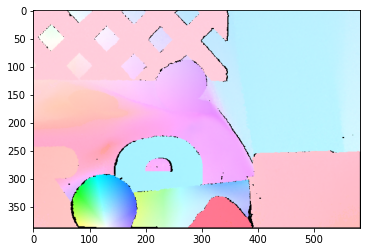

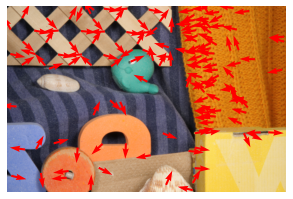

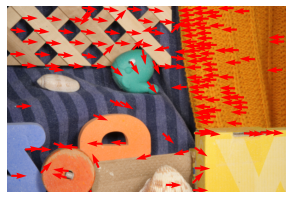

Average end point error =  96205009.96052803


In [349]:
urban_color, urban_gray = get_images("../data/all-frames-colour/RubberWhale/")
urban_gt_flow = helper.read_flow("../data/ground-truth-flow/RubberWhale/flow10.flo")
# print(urban_gt_flow)

helper.show_flow("../data/ground-truth-flow/RubberWhale/flow10.flo")

u = urban_gt_flow[:, :, 0]
v = urban_gt_flow[:, :, 1]
# print(u)

k = 3
flow_gt = []
points_and_flows = LukasKanadeForwardAdditive(urban_gray[k], urban_gray[k+1], (5,5), thresh=0.01, num_corners=150)
for pf in points_and_flows:
    j,i = int(pf[0]), int(pf[1])
    flow_gt.append([j, i, u[i,j], v[i,j]])
    # flow_gt.append(urban_gt_flow[])
    
flow_gt = np.array(flow_gt)
add_flow_to_image(urban_color[k], points_and_flows, only_flow = False)
add_flow_to_image(urban_color[k], flow_gt, only_flow = False)

print("Average end point error = ", average_end_point_error(points_and_flows, flow_gt))

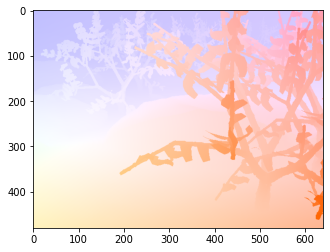

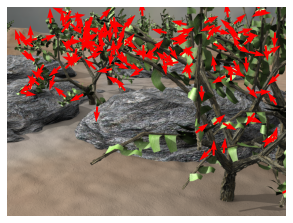

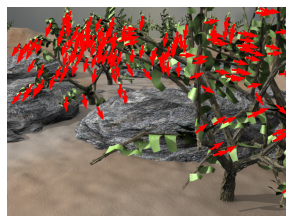

Average end point error =  3.613007864670786


In [351]:
urban_color, urban_gray = get_images("../data/all-frames-colour/Grove3/")
urban_gt_flow = helper.read_flow("../data/ground-truth-flow/Grove3/flow10.flo")
# print(urban_gt_flow)

helper.show_flow("../data/ground-truth-flow/Grove3/flow10.flo")

u = urban_gt_flow[:, :, 0]
v = urban_gt_flow[:, :, 1]
# print(u)

k = 3
flow_gt = []
points_and_flows = LukasKanadeForwardAdditive(urban_gray[k], urban_gray[k+1], (5,5), thresh=0.01, num_corners=150)
for pf in points_and_flows:
    j,i = int(pf[0]), int(pf[1])
    flow_gt.append([j, i, u[i,j], v[i,j]])
    # flow_gt.append(urban_gt_flow[])

flow_gt = np.array(flow_gt)
add_flow_to_image(urban_color[k], points_and_flows, only_flow = False)
add_flow_to_image(urban_color[k], flow_gt, only_flow = False)
print("Average end point error = ", average_end_point_error(points_and_flows, flow_gt))

### 3 Multi-Scale Coarse-to-fine Optical Flow

In [ ]:
def OpticalFlowRefine(img1, img2, initial_corners_and_flow, windowSize, thresh = 0.01):
    Ix = sobel(img1, 'x')
    Iy = sobel(img1, 'y')
    It = img2 - img1

    offset_i, offset_j = windowSize[0] // 2, windowSize[1] // 2

    corners_and_flow = []

    for cf in initial_corners_and_flow:
        # print(cf)
        j, i = int(cf[0]), int(cf[1])
        i_start, i_end = i - offset_i, i + offset_i + 1
        j_start, j_end = j - offset_j, j + offset_j + 1

        if not isValid(i_start, i_end, j_start, j_end, Ix.shape):
            continue
        
        A = np.vstack(( Ix[i_start:i_end, j_start:j_end].flatten(), Iy[i_start:i_end, j_start:j_end].flatten())).T
        ATA = A.T @ A

        w, _ = np.linalg.eig(ATA)
        if np.min(w) > thresh:
            B = -A.T @ It[i_start:i_end, j_start:j_end].flatten().T
            flow = np.linalg.pinv(ATA) @ B
            flow[0] += cf[2]
            flow[1] += cf[3]
            corners_and_flow.append([cf[0], cf[1], flow[0], flow[1]])

    return np.array(corners_and_flow)

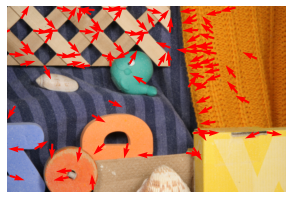

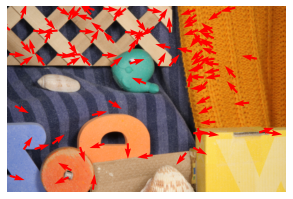

In [362]:
i = 0
p_f = LukasKanadeForwardAdditive(urban_gray[i], urban_gray[i+1], (5,5), thresh=0.01, num_corners=100)
add_flow_to_image(urban_color[i], p_f, only_flow = False)
for i in range(5):
    p_f = OpticalFlowRefine(urban_gray[i], urban_gray[i+1], p_f, (5,5))
add_flow_to_image(urban_color[i], p_f, only_flow = False)

In [363]:
def MultiScaleLucasKanade(img1, img2, windowSize, numLevels, num_corners = 200):
    sig, wind = 2, 7
    blur1 = gaussian_filter(img1, sig, truncate=(((wind - 1)/2) - sig)/sig)
    blur2 = gaussian_filter(img2, sig, truncate=(((wind - 1)/2) - sig)/sig)

    scaled_shape = int(2**(1-numLevels) * blur1.shape[0]), int(2**(1-numLevels) * blur1.shape[1])

    im1_scaled = cv2.resize(blur1, (scaled_shape[1], scaled_shape[0]))
    im2_scaled = cv2.resize(blur2, (scaled_shape[1], scaled_shape[0]))

    corners = (cv2.goodFeaturesToTrack(img1, num_corners, 0.05, 10)).reshape((-1, 2)).astype(int)
    corners = np.array([(c*2**(1-numLevels)) for c in corners]).astype(int)
    # print(corners.shape)

    points_and_flows = LukasKanadeForwardAdditive(im1_scaled, im2_scaled, windowSize, corners = corners, thresh = 0.01)

    for i in range(numLevels-2, -1, -1):
        im1_scaled = cv2.resize(im1_scaled, (im1_scaled.shape[1]*2, im1_scaled.shape[0]*2))
        im2_scaled = cv2.resize(im2_scaled, (im2_scaled.shape[1]*2, im2_scaled.shape[0]*2))
        
        points_and_flows = points_and_flows * 2
        # print(points_and_flows)

        for i in range(1):
            points_and_flows = OpticalFlowRefine(im1_scaled, im2_scaled, points_and_flows, windowSize)
            
    return points_and_flows

/home/laksh-nanwani/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


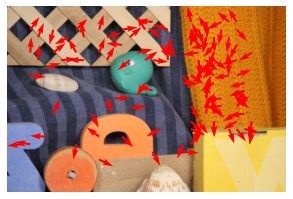

In [364]:
i = 0
points_and_flows = MultiScaleLucasKanade(urban_gray[i], urban_gray[i+1], (5,5), numLevels = 5, num_corners = 200)
add_flow_to_image(urban_color[i], points_and_flows, only_flow = False)

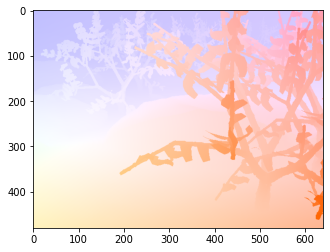

/home/laksh-nanwani/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


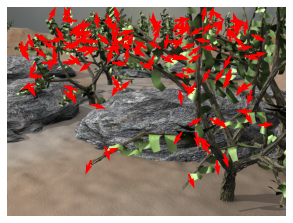

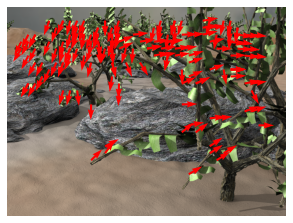

In [370]:
urban_color, urban_gray = get_images("../data/all-frames-colour/Grove3/")
urban_gt_flow = helper.read_flow("../data/ground-truth-flow/Grove3/flow10.flo")
# print(urban_gt_flow)

helper.show_flow("../data/ground-truth-flow/Grove3/flow10.flo")

u = urban_gt_flow[:, :, 0]
v = urban_gt_flow[:, :, 1]
# print(u)

k = 3
flow_gt = []
points_and_flows = MultiScaleLucasKanade(urban_gray[k], urban_gray[k+1], (5,5), numLevels = 5, num_corners = 200)
for pf in points_and_flows:
    j,i = int(pf[0]), int(pf[1])
    flow_gt.append([j, i, u[i,j], v[i,j]])
    # flow_gt.append(urban_gt_flow[])

flow_gt = np.array(flow_gt)
add_flow_to_image(urban_color[k], points_and_flows, only_flow = False)
add_flow_to_image(urban_color[k], flow_gt, only_flow = False)
# print("Average end point error = ", average_end_point_error(points_and_flows, flow_gt))

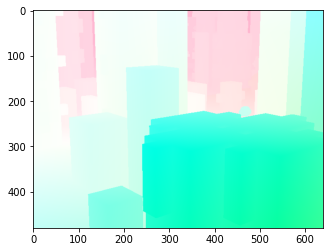

/home/laksh-nanwani/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


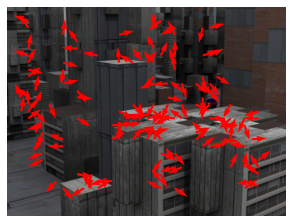

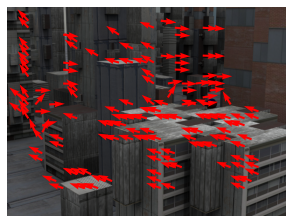

In [371]:
urban_color, urban_gray = get_images("../data/all-frames-colour/Urban2/")
urban_gt_flow = helper.read_flow("../data/ground-truth-flow/Urban2/flow10.flo")
# print(urban_gt_flow)

helper.show_flow("../data/ground-truth-flow/Urban2/flow10.flo")

u = urban_gt_flow[:, :, 0]
v = urban_gt_flow[:, :, 1]
# print(u)

k = 3
flow_gt = []
points_and_flows = MultiScaleLucasKanade(urban_gray[k], urban_gray[k+1], (5,5), numLevels = 5, num_corners = 200)
for pf in points_and_flows:
    j,i = int(pf[0]), int(pf[1])
    flow_gt.append([j, i, u[i,j], v[i,j]])
    # flow_gt.append(urban_gt_flow[])

flow_gt = np.array(flow_gt)
add_flow_to_image(urban_color[k], points_and_flows, only_flow = False)
add_flow_to_image(urban_color[k], flow_gt, only_flow = False)
# print("Average end point error = ", average_end_point_error(points_and_flows, flow_gt))

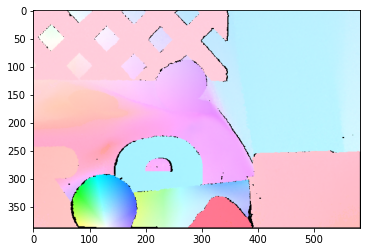

/home/laksh-nanwani/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


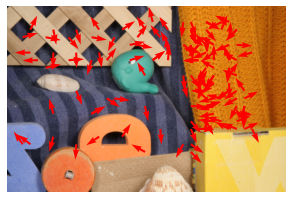

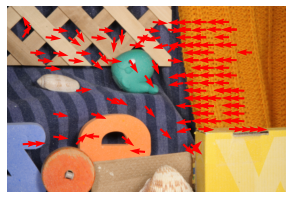

In [372]:
urban_color, urban_gray = get_images("../data/all-frames-colour/RubberWhale/")
urban_gt_flow = helper.read_flow("../data/ground-truth-flow/RubberWhale/flow10.flo")
# print(urban_gt_flow)

helper.show_flow("../data/ground-truth-flow/RubberWhale/flow10.flo")

u = urban_gt_flow[:, :, 0]
v = urban_gt_flow[:, :, 1]
# print(u)

k = 3
flow_gt = []
points_and_flows = MultiScaleLucasKanade(urban_gray[k], urban_gray[k+1], (5,5), numLevels = 5, num_corners = 200)
for pf in points_and_flows:
    j,i = int(pf[0]), int(pf[1])
    flow_gt.append([j, i, u[i,j], v[i,j]])
    # flow_gt.append(urban_gt_flow[])

flow_gt = np.array(flow_gt)
add_flow_to_image(urban_color[k], points_and_flows, only_flow = False)
add_flow_to_image(urban_color[k], flow_gt, only_flow = False)
# print("Average end point error = ", average_end_point_error(points_and_flows, flow_gt))